In [1]:
import numpy as np

import pandas as pd

In [2]:
df = pd.read_csv('../notebook _ app-BZ/0-0-all_news_pc_with_hs_by_news.csv', index_col = [0])

In [3]:
# define >0 as 1; <=0 as 0
def to_pc_class (x):
    if x > 0:
        return 1
    else:
        return 0
# def to_pc_class (x):
#     if x >= 0.03:
#         return 1
#     else:
#         return 0

In [4]:
df['pc_class']=df['price_change'].map(to_pc_class)

In [5]:
X = df["headline"].fillna("fillna")
y = df["pc_class"]

In [6]:
split_test = int(len(y) * 0.7)
X_train = X[0:split_test]
X_test = X[split_test:]
y_train = y[0:split_test]
y_test = y[split_test:]

In [7]:
X_train

19        Cisco earnings should benefit from enterprise ...
20                    Reflecting on Twenty Years of NetHope
21        Cisco’s Earnings Are Wednesday. Expect News on...
22        Dish, Cisco Collaborate To Sell 5G To Enterprises
23        Silicon Photonics Explained: Cisco Optics Podc...
                                ...                        
362374    Centene Corp. stock underperforms Friday when ...
362375    Centene Corp. stock outperforms market on stro...
362376    Vancity Investment Management Ltd Buys Salesfo...
362377    Centene Corp. stock outperforms market on stro...
362378    Centene (CNC) Expands Medicare Advantage Offer...
Name: headline, Length: 351066, dtype: object

<AxesSubplot:ylabel='pc_class'>

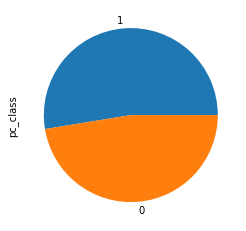

In [8]:
y.value_counts().plot(kind='pie')

In [9]:
import nltk
import re
from nltk.corpus import stopwords

In [10]:
# #Dataset Preprosessing
# from nltk.stem.porter import PorterStemmer
# def stem_tokenizer(text):
#     ps = PorterStemmer()
#     corpus = []
#     for i in range(len(X)):

#         headline= re.sub('[^a-zA-Z]',' ',X[i])
        
#         headline = headline.lower()
#         # stopwords like “not”,"aren't" will be removed, will cause problems.
#         headline = headline.split()
#         headline = [ps.stem(word) for word in headline]
#         headline = ' '.join(headline)
#         corpus.append(headline)
#     return corpus
    

In [11]:
from nltk.stem.porter import PorterStemmer
def stem_tokenizer(text):
    ps = PorterStemmer()
    words = re.sub(r"[^A-Za-z0-9\-]", " ", text).lower().split()
    words = [ps.stem(word) for word in words]
    return words 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [38]:
cv = CountVectorizer(
                     tokenizer=stem_tokenizer,
                    max_df=0.5,
                    min_df=5,
                    ngram_range=(1, 2))

In [39]:
# cv.fit_transform(X_train[1:500])

# Logistic Regression Model

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [41]:
# lg = LogisticRegression(penalty='l1', C = 1, solver = 'saga', n_jobs =-1)
# lg = LogisticRegression()

In [42]:
steps = [('cv',cv),
        ('lg',LogisticRegression(max_iter = 1000))]
lg_model = Pipeline(steps)

In [43]:

lg_model.fit(X_train,y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.5, min_df=5, ngram_range=(1, 2),
                                 tokenizer=<function stem_tokenizer at 0x0000021C09A01820>)),
                ('lg', LogisticRegression(max_iter=1000))])

In [44]:
from sklearn.metrics import roc_auc_score, classification_report


# print(precision_score(y_pred,y_test))
# # print(recall_score(model.predict(X_test,batch_size=1024),y_test))
print ('the AUC score is {}'.format(roc_auc_score(y_test,lg_model.predict(X_test))))
print(classification_report(y_test,lg_model.predict(X_test)))
print(classification_report(y_train,lg_model.predict(X_train)))

the AUC score is 0.5465193366751708
              precision    recall  f1-score   support

           0       0.53      0.49      0.51     71832
           1       0.56      0.60      0.58     78625

    accuracy                           0.55    150457
   macro avg       0.55      0.55      0.55    150457
weighted avg       0.55      0.55      0.55    150457

              precision    recall  f1-score   support

           0       0.75      0.65      0.70    166039
           1       0.72      0.80      0.76    185027

    accuracy                           0.73    351066
   macro avg       0.73      0.73      0.73    351066
weighted avg       0.73      0.73      0.73    351066



In [34]:
grams = [''] * len(lg_model['cv'].vocabulary_)
for k, v in lg_model['cv'].vocabulary_.items():
    grams[v] = k

In [35]:
gram_weight = list(zip(grams, lg_model['lg'].coef_[0]))
gram_weight.sort(key=lambda x: x[1])

In [36]:
gram_weight[:5]

[('danah price', -2.5660289645902914),
 ('of third-quart', -2.248685281509173),
 ('dennison to', -2.1395465164146223),
 ('twitter price', -2.017727906352048),
 ('intuit price', -1.986153346949316)]

In [37]:
gram_weight[-5:]

[('from covid', 1.8567339447496347),
 ('financi outlook', 1.908450351188457),
 ('sherwin-william price', 1.9836594605511892),
 ('walgreen mywalgreen', 1.9888948186074389),
 ('leido to', 2.435262487271741)]

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
                        tokenizer=stem_tokenizer,
                        lowercase=True,
                        max_df=0.5,
                        min_df=20,
                        ngram_range=(1, 2)
                       )

In [56]:
lgclassifier = Pipeline([('tfidf', tfidf), ('lg', LogisticRegression(max_iter = 1000))])

In [57]:
lgclassifier.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, min_df=20, ngram_range=(1, 2),
                                 tokenizer=<function stem_tokenizer at 0x0000021C09A01820>)),
                ('lg', LogisticRegression(max_iter=1000))])

In [58]:
from sklearn.metrics import roc_auc_score, classification_report


# print(precision_score(y_pred,y_test))
# # print(recall_score(model.predict(X_test,batch_size=1024),y_test))
print ('the AUC score is {}'.format(roc_auc_score(y_test,lg_model.predict(X_test))))
print(classification_report(y_test,lg_model.predict(X_test)))
print(classification_report(y_train,lg_model.predict(X_train)))

the AUC score is 0.5465193366751708
              precision    recall  f1-score   support

           0       0.53      0.49      0.51     71832
           1       0.56      0.60      0.58     78625

    accuracy                           0.55    150457
   macro avg       0.55      0.55      0.55    150457
weighted avg       0.55      0.55      0.55    150457

              precision    recall  f1-score   support

           0       0.75      0.65      0.70    166039
           1       0.72      0.80      0.76    185027

    accuracy                           0.73    351066
   macro avg       0.73      0.73      0.73    351066
weighted avg       0.73      0.73      0.73    351066



In [51]:
grams = [''] * len(lgclassifier['tfidf'].vocabulary_)
for k, v in lgclassifier['tfidf'].vocabulary_.items():
    grams[v] = k

In [52]:
gram_weight = list(zip(grams, lgclassifier['lg'].coef_[0]))
gram_weight.sort(key=lambda x: x[1])

In [53]:
gram_weight[:5]

[('trump', -2.757505267363266),
 ('3 5', -2.5561237028754253),
 ('20th option', -2.3828295740582646),
 ('twitter price', -2.1918000387959964),
 ('danah price', -2.1474558544029696)]

In [54]:
gram_weight[-5:]

[('file form', 2.1383954022734915),
 ('walgreen mywalgreen', 2.2916767205245674),
 ('august 27th', 2.4097685501303148),
 ('abbott', 2.5525481223843944),
 ('twitter suspend', 2.671070479077651)]